<a href="https://colab.research.google.com/github/cgrundman/ZTM-TensorFlow-Developer/blob/main/07_milestone_project_1_food_vision_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

## Check GPU

* Coogle Colab offeres free GPUs (thank you Google), however, not all of them are compatible with mixed precision training.

In order touse mixed precision trainin we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus#compute).

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-756ae205-fd00-a725-b1b7-9297870d5bb7)


## Get helper functions

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-03 15:46:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-03 15:46:52 (85.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datassets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Download Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Expoloring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The dataype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.nupy()]}
  """)

In [12]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 19,   6,   0],
        [ 29,  16,   8],
        [ 34,  21,  13],
        ...,
        [ 36,  19,   3],
        [ 35,  19,   3],
        [ 36,  20,   4]],

       [[ 20,   7,   0],
        [ 28,  15,   7],
        [ 34,  21,  13],
        ...,
        [ 37,  20,   4],
        [ 37,  20,   4],
        [ 37,  21,   5]],

       [[ 20,   7,   0],
        [ 25,  12,   4],
        [ 31,  18,  10],
        ...,
        [ 40,  21,   4],
        [ 40,  21,   4],
        [ 39,  22,   4]],

       ...,

       [[208, 206, 194],
        [209, 207, 195],
        [211, 209, 197],
        ...,
        [192, 196, 179],
        [190, 194, 177],
        [203, 207, 190]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [203, 207, 190],
        [211, 214, 197],
        [202, 205, 186]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [200, 204, 18

In [13]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

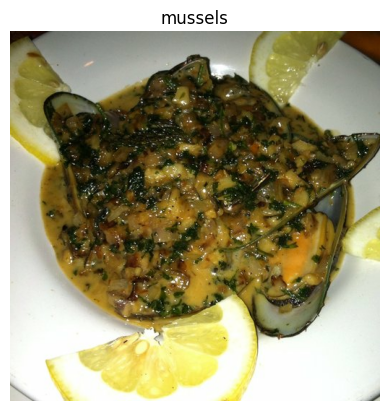

In [16]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image.numpy())
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functino for our data

Neural Networks perform best when data is in a certain way (e.g. batched, normalized, etc).

Hewver, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing function and map it to your data.

What we know about our data:
* In `uint8` datatype
* Conprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` type (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size.
* Scales (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackel with a preprocessing function.
Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in)

This means out functions need to:
1. Reshape our images of all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [17]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[19  6  0]
  [29 16  8]
  [34 21 13]
  ...
  [36 19  3]
  [35 19  3]
  [36 20  4]]

 [[20  7  0]
  [28 15  7]
  [34 21 13]
  ...
  [37 20  4]
  [37 20  4]
  [37 21  5]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[25.244898   12.244898    4.7295923 ]
  [32.40816    19.408163   11.408163  ]
  [32.719387   19.719387   10.719387  ]
  ...
  [39.005093   20.994862    3.4999783 ]
  [36.31123    19.31123     2.1173685 ]
  [36.413277   20.000034    4.000035  ]]

 [[19.897957    6.897958    0.18367267]
  [28.943878   15.943878    7.9438777 ]
  [22.112244    9.112244    1.1122437 ]
  ...
  [48.89794    27.015284    6.1428356 ]
  [44.642845   23.852028    3.0714417 ]
  [42.7602     21.954084    3.0714283 ]]]..., 
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

In [20]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

"Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Creating modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* Model/Checkpoint callback to save our model's progress after feature extraction


In [22]:
# Create tensorboard callback (import from help_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide: https://www.tensorflow.org/guide/mixed_precision

In [23]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

## Checking layer dtype policies (are we using mixed precision?)

In [28]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer-trainable`: is the layer trainable or not? (if `False`